In [30]:
import os
from pathlib import Path
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from collections import Counter
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
import torchvision.models as models

In [31]:
DATA_DIR = r"C:\Users\manshisingh\Downloads\documents\archive (2)\leapGestRecog"  # dataset folder
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 10
LR = 1e-4
VAL_SPLIT = 0.2
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [32]:
# -------------------------------
# 2️⃣ Custom Dataset
# -------------------------------
class GestureDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = Path(root_dir)
        self.transform = transform
        self.data = []
        self.labels = []

        for main_folder in sorted(os.listdir(root_dir)):
            main_path = self.root_dir / main_folder
            if main_path.is_dir():
                for gesture_folder in sorted(os.listdir(main_path)):
                    gesture_path = main_path / gesture_folder
                    if gesture_path.is_dir():
                        for img_file in os.listdir(gesture_path):
                            if img_file.lower().endswith((".png", ".jpg", ".jpeg")):
                                self.data.append(str(gesture_path / img_file))
                                self.labels.append(gesture_folder)

        self.classes = sorted(list(set(self.labels)))
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.classes)}
        self.labels_idx = [self.class_to_idx[label] for label in self.labels]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data[idx]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            image = self.transform(image)
        label = self.labels_idx[idx]
        return image, label

In [33]:
# -------------------------------
# Step 5: Transformations & DataLoader
# -------------------------------
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((128, 128)),  # change size as needed
    transforms.ToTensor()
])
dataset = GestureDataset(DATA_DIR, transform=transform)


In [34]:
def perform_eda(root_dir):
    gesture_counts = {}
    sample_images = {}

    root_dir = Path(root_dir)
    
    print("DEBUG: Root directory:", root_dir)
    
    for main_folder in sorted(os.listdir(root_dir)):
        main_path = root_dir / main_folder
        print("DEBUG: Main folder:", main_path)
        if main_path.is_dir():
            for gesture_folder in sorted(os.listdir(main_path)):
                gesture_path = main_path / gesture_folder
                print("DEBUG: Gesture folder:", gesture_path)
                if gesture_path.is_dir():
                    imgs = os.listdir(gesture_path)
                    print(f"DEBUG: Found {len(imgs)} images in {gesture_folder}")
                    gesture_counts[gesture_folder] = gesture_counts.get(gesture_folder, 0) + len(imgs)
                    
                    if gesture_folder not in sample_images and len(imgs) > 0:
                        sample_images[gesture_folder] = str(gesture_path / imgs[0])

    # Summary
    print("📊 Dataset Summary:")
    print(f"Total gesture classes: {len(gesture_counts)}")
    print(f"Total images: {sum(gesture_counts.values())}\n")
    
    return gesture_counts, sample_images

# Run
gesture_counts, sample_images = perform_eda(DATA_DIR)


DEBUG: Root directory: C:\Users\manshisingh\Downloads\documents\archive (2)\leapGestRecog
DEBUG: Main folder: C:\Users\manshisingh\Downloads\documents\archive (2)\leapGestRecog\00
DEBUG: Gesture folder: C:\Users\manshisingh\Downloads\documents\archive (2)\leapGestRecog\00\01_palm
DEBUG: Found 200 images in 01_palm
DEBUG: Gesture folder: C:\Users\manshisingh\Downloads\documents\archive (2)\leapGestRecog\00\02_l
DEBUG: Found 200 images in 02_l
DEBUG: Gesture folder: C:\Users\manshisingh\Downloads\documents\archive (2)\leapGestRecog\00\03_fist
DEBUG: Found 200 images in 03_fist
DEBUG: Gesture folder: C:\Users\manshisingh\Downloads\documents\archive (2)\leapGestRecog\00\04_fist_moved
DEBUG: Found 200 images in 04_fist_moved
DEBUG: Gesture folder: C:\Users\manshisingh\Downloads\documents\archive (2)\leapGestRecog\00\05_thumb
DEBUG: Found 200 images in 05_thumb
DEBUG: Gesture folder: C:\Users\manshisingh\Downloads\documents\archive (2)\leapGestRecog\00\06_index
DEBUG: Found 200 images in 06_

In [35]:
# -------------------------------
# 4️⃣ Dataset Overview
# -------------------------------
print("📊 Dataset Overview:")
print(f"Total images: {len(dataset)}")
print(f"Number of gesture classes: {len(dataset.classes)}")
print(f"Gesture Categories: {dataset.classes}")

📊 Dataset Overview:
Total images: 20000
Number of gesture classes: 10
Gesture Categories: ['01_palm', '02_l', '03_fist', '04_fist_moved', '05_thumb', '06_index', '07_ok', '08_palm_moved', '09_c', '10_down']


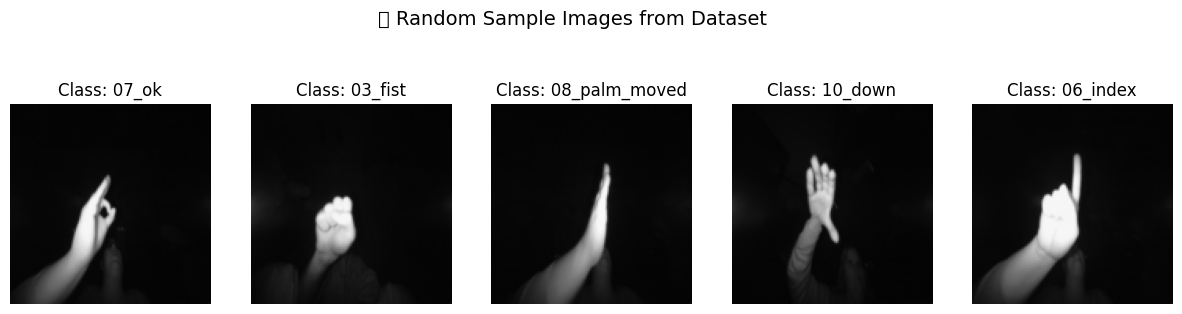

In [36]:
# Random sample images
num_samples = 5
indices = np.random.choice(len(dataset), num_samples, replace=False)

plt.figure(figsize=(15, 4))
for i, idx in enumerate(indices):
    image, label = dataset[idx]
    image_np = image.permute(1, 2, 0).numpy()
    plt.subplot(1, num_samples, i + 1)
    plt.imshow(image_np)
    plt.title(f"Class: {dataset.classes[label]}")
    plt.axis("off")
plt.suptitle("🖼️ Random Sample Images from Dataset", fontsize=14)
plt.show()


🖼️ Sample image shape (C, H, W): torch.Size([3, 128, 128])


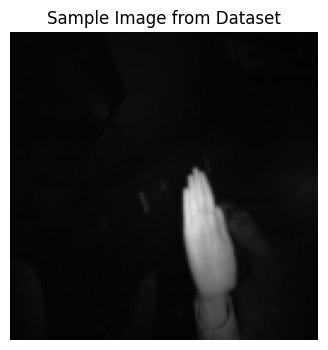

In [37]:
sample_img, _ = dataset[0]
print(f"🖼️ Sample image shape (C, H, W): {sample_img.shape}")

# Show the sample image
img_np = sample_img.permute(1, 2, 0).numpy()
plt.figure(figsize=(4, 4))
plt.imshow(img_np)
plt.title("Sample Image from Dataset")
plt.axis("off")
plt.show()


C:\Users\manshisingh\AppData\Local\Temp\ipykernel_1888\1380684123.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(gesture_counts.keys()), y=list(gesture_counts.values()), palette="viridis")


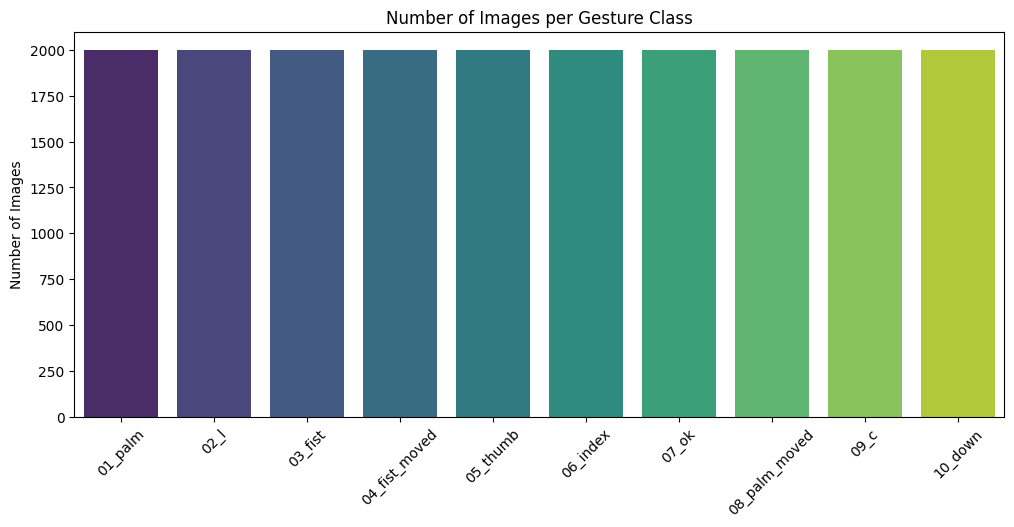

In [38]:

    # Plot class distribution
    plt.figure(figsize=(12,5))
    sns.barplot(x=list(gesture_counts.keys()), y=list(gesture_counts.values()), palette="viridis")
    plt.xticks(rotation=45)
    plt.ylabel("Number of Images")
    plt.title("Number of Images per Gesture Class")
    plt.show()


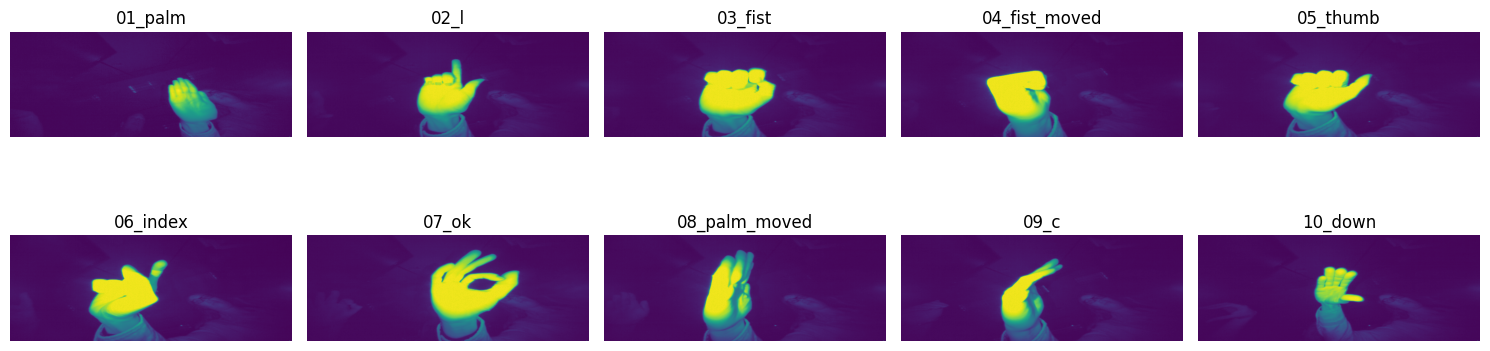

In [39]:
plt.figure(figsize=(15, 5))
for i, (gesture, img_path) in enumerate(sample_images.items()):
    if i >= 10:  # max 10 samples
        break
    img = mpimg.imread(img_path)
    plt.subplot(2, 5, i+1)
    plt.imshow(img)
    plt.title(gesture)
    plt.axis("off")

plt.tight_layout()
plt.show()

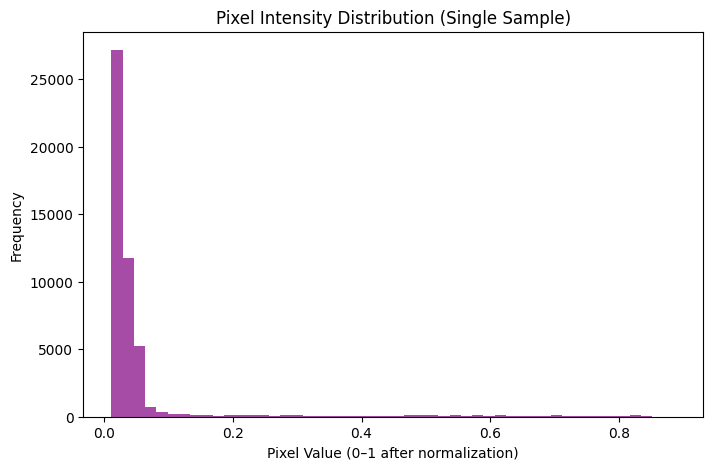

In [40]:
# -------------------------------
# Pixel Intensity Distribution (Brightness)
# -------------------------------
sample_img_np = sample_img.numpy().transpose((1, 2, 0))
plt.figure(figsize=(8, 5))
plt.hist(sample_img_np.ravel(), bins=50, color='purple', alpha=0.7)
plt.title("Pixel Intensity Distribution (Single Sample)")
plt.xlabel("Pixel Value (0–1 after normalization)")
plt.ylabel("Frequency")
plt.show()

In [41]:

# Split dataset
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [42]:
# -------------------------------
# Step 6: Simple CNN Model
# -------------------------------
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),  # 64 -> 32
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),  # 32 -> 16
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(),
            nn.AdaptiveAvgPool2d((1,1))  # 128 x 1 x 1
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x
      

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN(num_classes=len(dataset.classes)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [43]:
# -------------------------------
# Step 7: Train Model (Fast)
# -------------------------------
num_epochs = 3  # change to 10+ for full training
for epoch in range(num_epochs):
    model.train()
    running_loss = 0
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

100%|██████████| 500/500 [12:33<00:00,  1.51s/it]


Epoch [1/3], Loss: 1.7667


100%|██████████| 500/500 [14:30<00:00,  1.74s/it]


Epoch [2/3], Loss: 0.5712


100%|██████████| 500/500 [13:27<00:00,  1.61s/it]

Epoch [3/3], Loss: 0.2505


In [51]:
# -------------------------------
# Step 8: Evaluate Model
# -------------------------------
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        

print(f"Test Accuracy: {100 * correct / total:.2f}%")

Test Accuracy: 95.88%


In [50]:
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


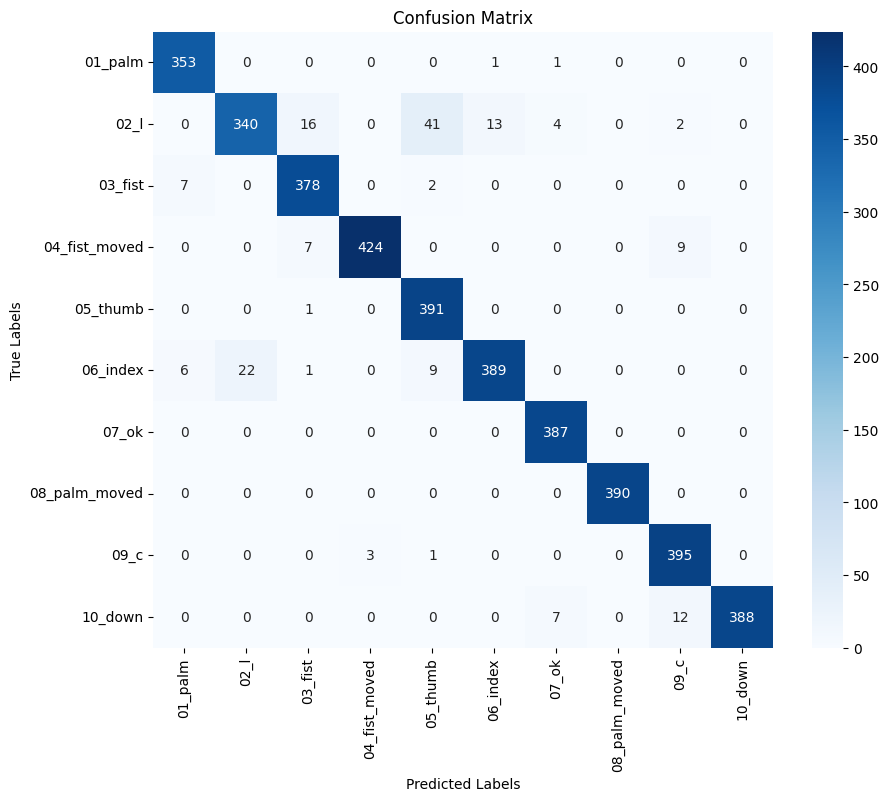


📋 Classification Report:

               precision    recall  f1-score   support

      01_palm       0.96      0.99      0.98       355
         02_l       0.94      0.82      0.87       416
      03_fist       0.94      0.98      0.96       387
04_fist_moved       0.99      0.96      0.98       440
     05_thumb       0.88      1.00      0.94       392
     06_index       0.97      0.91      0.94       427
        07_ok       0.97      1.00      0.98       387
08_palm_moved       1.00      1.00      1.00       390
         09_c       0.94      0.99      0.97       399
      10_down       1.00      0.95      0.98       407

     accuracy                           0.96      4000
    macro avg       0.96      0.96      0.96      4000
 weighted avg       0.96      0.96      0.96      4000



In [52]:
# -------------------------------
# Confusion Matrix
# -------------------------------

from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# -------------------------------
# Classification Report
# -------------------------------
print("\n📋 Classification Report:\n")
print(classification_report(all_labels, all_preds, target_names=dataset.classes))

True


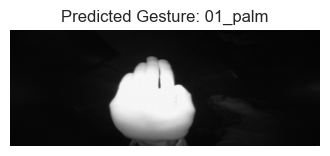

In [ ]:
# -------------------------------
# Step 9: Predict Single Image
# -------------------------------
def predict_image(img_path):
    if not os.path.exists(img_path):
        print("❌ Image file not found:", img_path)
        return

    image = cv2.imread(img_path)
    if image is None:
        print("❌ Failed to read image (maybe corrupted):", img_path)
        return

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Prepare image for model
    input_tensor = transform(image_rgb).unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        output = model(input_tensor)
        _, pred = torch.max(output, 1)
        gesture = dataset.classes[pred.item()]

    # Show image with prediction
    plt.figure(figsize=(4,4))
    plt.imshow(image_rgb)
    plt.title(f"Predicted Gesture: {gesture}")
    plt.axis("off")
    plt.show()

img_path = r"C:\Users\manshisingh\Downloads\documents\archive (2)\leapGestRecog\00\01_palm\frame_00_01_0024.png"
print(os.path.exists(img_path))  # should print True
predict_image(img_path)

